#### Olist Schema Implementation

The datasets provided by Olist on Kaggle can be used in Star Schema with minimum effort. Once the csv files are uploaded in to the database, the steps to take are listed as below.

1) Find the features on each table

2) Create the Schema around the features

3) Decide the features that are going to be on the facttable and dimtables

4) Create the facttable referencing the other dim tables

In case of Olist, the dim_tables are already created. Lets get started with drawing the schema

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import configparser
import psycopg2

config = configparser.ConfigParser()
config.read('clusteroli.config')

db = config['POSTGRES']['PG_DB']
user = config['POSTGRES']['PG_UNAME']
passwd = config['POSTGRES']['PG_PASS']
port = config['POSTGRES']['PG_PORT']
host = config['POSTGRES']['PG_HOST']

In [2]:
credentials = "postgresql://{}:{}@{}:{}/{}".format(user,passwd,host,port,db)

#using psycopg2 to test connection since there are no tables
import psycopg2
try:
    conn = psycopg2.connect(host=host,dbname=db,user=user,password=passwd,port=port)
except Exception as e:
    print(e)
    
conn.set_session(autocommit=True)

try:
    cur = conn.cursor()
    
except:
    print(e)

#Helper functions to work with the database
def schemaGen(dataframe, schemaName):
    localSchema = pd.io.sql.get_schema(dataframe,schemaName)
    localSchema = localSchema.replace('TEXT','VARCHAR(255)').replace('INTEGER','NUMERIC').replace('\n','').replace('"',"")
    return "".join(localSchema)

#Using pandas read_sql for getting schema
def getSchema(tableName):
    schema = pd.read_sql("""SELECT * FROM information_schema.columns where table_name='{}'""".format(tableName),credentials)
    return schema

#Issue is in using pd.read_sql to write data to the database. so using psycopg2
def queryTable(query):
    try:
        schema = cur.execute(query)
        return 
    except Exception as e:
        print(e)
        
#This doesn't return anything

#Using the pd.read_sql for getting data from db
def queryBase(query):
    requiredTable = pd.read_sql(query,con=credentials)
    return requiredTable

#This returns the dataframe

In [31]:
#Get the tables from the database. There are 9 tables
dataTables = queryBase("""SELECT table_name FROM information_schema.tables""")[:9]

In [35]:
dataTables=dataTables.table_name.values

In [38]:
for name in dataTables:
    print(name)
    print(getSchema(name).column_name.values)

dim_location
['customer_zip_code_prefix' 'customer_id' 'customer_unique_id'
 'customer_city' 'customer_state']
dim_orders
['order_item_id' 'price' 'freight_value' 'shipping_limit_date' 'seller_id'
 'product_id' 'order_id']
dim_payment
['payment_sequential' 'payment_installments' 'payment_value' 'order_id'
 'payment_type']
dim_reviews
['review_score' 'order_id' 'review_id' 'review_comment_message'
 'review_creation_date' 'review_answer_timestamp' 'review_comment_title']
dim_process
['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date']
dim_product
['product_width_cm' 'product_length_cm' 'product_height_cm'
 'product_name_lenght' 'product_description_lenght' 'product_photos_qty'
 'product_weight_g' 'product_category_name' 'product_id']
dim_seller
['seller_zip_code_prefix' 'seller_id' 'seller_city' 'seller_state']
dim_category
['product_category_name' 'product

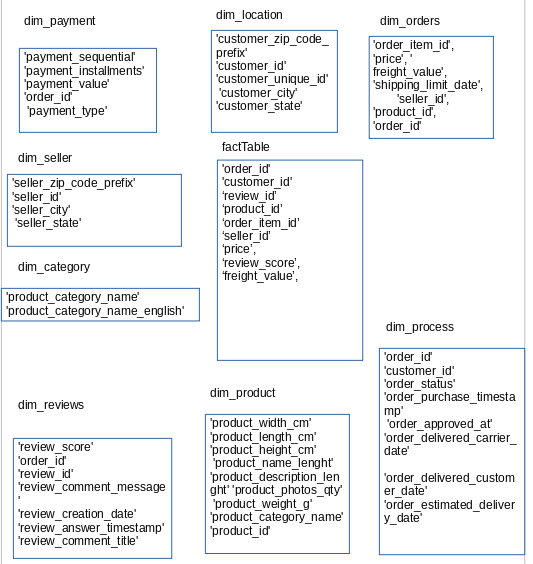

In [ ]:
# Before building the facttable, the keys that are referenced has to be primary key or key with 
#unique constraints using ALTER TABLE history ADD PRIMARY KEY (id)



In [39]:
createfact = """CREATE TABLE facttable(factkey BIGSERIAL PRIMARY KEY,
                        orderkey VARCHAR REFERENCES dim_process(order_id),
                        customerkey VARCHAR REFERENCES dim_location(customer_id),
                        productkey VARCHAR REFERENCES dim_product(product_id),
                        sellerkey VARCHAR REFERENCES dim_seller(seller_id),
                        price REAL, review_id VARCHAR, 
                        review_comment_message VARCHAR,
                        review_score REAL,
                        frieght_value REAL)"""
queryTable(createfact)

In [35]:
#"do" should not be used  in the aliases
checkquery = """SELECT dm.order_id AS orderkey, dl.customer_id AS customerkey,
                        dp.product_id AS productkey, ds.seller_id AS sellerkey,
                        dw.review_id,
                        dw.review_comment_message
                FROM dim_process as dm
                JOIN dim_location as dl ON dl.customer_id = dm.customer_id
                JOIN dim_orders as dr ON dm.order_id = dr.order_id
                JOIN dim_product as dp ON dr.product_id = dp.product_id
                JOIN dim_seller as ds ON dr.seller_id = ds.seller_id
                JOIN dim_reviews as dw ON dr.order_id = dw.order_id
                LIMIT 5"""
queryBase(checkquery)

,orderkey,customerkey,productkey,sellerkey,review_id,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,7bc2406110b926393aa56f80a40eba40,None
1,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,7bc2406110b926393aa56f80a40eba40,None
2,a548910a1c6147796b98fdf73dbeba33,8a2e7ef9053dea531e4dc76bd6d853e6,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,80e641a11e56f04c1ad469d5645fdfde,None
3,f9e4b658b201a9f2ecdecbb34bed034b,e226dfed6544df5b7b87a48208690feb,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,228ce5500dc1d8e020d8d1322874b6f0,None
4,82c5edeff15e09a0460d292874766132,deb1ce7ca68ee64461402e881a1c02ae,22ca1399dde9714934f8ec09b6aca2fe,128f9bfbe4c7d5185033914b1de3d39a,23f570a1b0db9566bee04521a0410c54,None


In [44]:
insertFact = """INSERT INTO facttable(orderkey, customerkey, productkey, sellerkey,
                                    price, review_id, review_comment_message,
                                    review_score, frieght_value)
                SELECT dm.order_id AS orderkey, dl.customer_id AS customerkey,
                        dp.product_id AS productkey, ds.seller_id AS sellerkey,
                        dr.price AS price, dw.review_id AS review_id, 
                        dw.review_comment_message AS review_commment_message,
                        dw.review_score AS review_score,
                        dr.freight_value AS frieght_value
                FROM dim_process as dm
                JOIN dim_location as dl ON dl.customer_id = dm.customer_id
                JOIN dim_orders as dr ON dm.order_id = dr.order_id
                JOIN dim_product as dp ON dr.product_id = dp.product_id
                JOIN dim_seller as ds ON dr.seller_id = ds.seller_id
                JOIN dim_reviews as dw ON dr.order_id = dw.order_id"""
queryTable(insertFact)

In [45]:
queryBase("""SELECT * FROM facttable LIMIT 5""")

,factkey,orderkey,customerkey,productkey,sellerkey,price,review_id,review_comment_message,review_score,frieght_value
0,1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,7b07bacd811c4117b742569b04ce3580,None,4.0,19.93
1,2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,0c5b33dea94867d1ac402749e5438e8b,Chegou antes do prazo previsto e o produto sur...,5.0,17.87
2,3,00048cc3ae777c65dbb7d2a0634bc1ea,816cbea969fe5b689b39cfc97a506742,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,21.90,5e4e50af3b7960b7a10d86ec869509e8,None,4.0,12.69
3,4,0005a1a1728c9d785b8e2b08b904576c,16150771dfd4776261284213b89c304e,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,145.95,67b1ab8f3ec19d5a90f153f21757d3a1,Na descrição do produto quando fui efetuar a c...,1.0,11.65
4,5,00061f2a7bc09da83e415a52dc8a4af1,c6fc061d86fab1e2b2eac259bac71a49,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,59.99,7e92c32ae297ef950ee69781d9f1760c,A caixa do produto veio com uma pequena avaria...,5.0,8.88
